# 🌎 Welcome to the CSE151B Spring 2025 Climate Emulation Competition!

Thank you for participating in this exciting challenge focused on building machine learning models to emulate complex climate systems.  
This notebook is provided as a **starter template** to help you:

- Understand how to load and preprocess the dataset  
- Construct a baseline model  
- Train and evaluate predictions using a PyTorch Lightning pipeline  
- Format your predictions for submission to the leaderboard  

You're encouraged to:
- Build on this structure or replace it entirely
- Try more advanced models and training strategies
- Incorporate your own ideas to push the boundaries of what's possible

If you're interested in developing within a repository structure and/or use helpful tools like configuration management (based on Hydra) and logging (with Weights & Biases), we recommend checking out the following Github repo. Such a structure can be useful when running multiple experiments and trying various research ideas.

👉 [https://github.com/salvaRC/cse151b-spring2025-competition](https://github.com/salvaRC/cse151b-spring2025-competition)

Good luck, have fun, and we hope you learn a lot through this process!


### 📦 Install Required Libraries
We install the necessary Python packages for data loading, deep learning, and visualization.


In [4]:
!pip install xarray zarr dask lightning matplotlib wandb cftime einops --quiet

import os
from datetime import datetime
import numpy as np
import xarray as xr
import dask.array as da
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import lightning.pytorch as pl


In [7]:
!pip install kaggle
!kaggle competitions download -c cse151b-spring2025-competition -p ./data

Defaulting to user installation because normal site-packages is not writeable
/bin/bash: line 1: kaggle: command not found


In [11]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Replace 'titanic' with your competition slug
#api.competition_download_files('cse151b-spring2025-competition', path='data')
import zipfile

with zipfile.ZipFile("data/cse151b-spring2025-competition.zip", 'r') as zip_ref:
    zip_ref.extractall("data/cse151b-spring2025-competition")

### ⚙️ Configuration Setup  
Define all model, data, and training hyperparameters in one place for easy control and reproducibility.

### 📊 Data Configuration

We define the dataset settings used for training and evaluation. This includes:

- **`path`**: Path to the `.zarr` dataset containing monthly climate variables from CMIP6 simulations.
- **`input_vars`**: Climate forcing variables (e.g., CO₂, CH₄) used as model inputs.
- **`output_vars`**: Target variables to predict — surface air temperature (`tas`) and precipitation (`pr`).
- **`target_member_id`**: Ensemble member to use from the simulations (each SSP has 3) for target variables.
- **`train_ssps`**: SSP scenarios used for training (low to high emissions).
- **`test_ssp`**: Scenario held out for evaluation (Must be set to SSP245).
- **`test_months`**: Number of months to include in the test split (Must be set to 120).
- **`batch_size`** and **`num_workers`**: Data loading parameters for PyTorch training.

These settings reflect how the challenge is structured: models must learn from some emission scenarios and generalize to unseen ones.

> ⚠️ **Important:** Do **not modify** the following test settings:
>
> - `test_ssp` must remain **`ssp245`**, which is the held-out evaluation scenario.
> - `test_months` must be **`120`**, corresponding to the last 10 years (monthly resolution) of the scenario.



In [22]:
#NOTE Change the data directory according to where you have your zarr files stored
config = {
    "data": {
        "path": "data/cse151b-spring2025-competition/processed_data_cse151b_v2_corrupted_ssp245/processed_data_cse151b_v2_corrupted_ssp245.zarr",
        "input_vars": ["CO2", "SO2", "CH4", "BC", "rsdt"],
        "output_vars": ["tas", "pr"],
        "target_member_id": 0,
        "train_ssps": ["ssp126", "ssp370", "ssp585"],
        "test_ssp": "ssp245",
        "test_months": 360,
        "batch_size": 64,
        "num_workers": 4,
    },
    "model": {
        "type": "simple_cnn",
        "kernel_size": 3,
        "init_dim": 64,
        "depth": 4,
        "dropout_rate": 0.1,
    },
    "training": {
        "lr": 1e-3,
        "optimizer": {
            "type": "SGD",
            "momentum": 0.9,
            "weight_decay": 1e-4
        },
        "scheduler": {
            "type": "ReduceLROnPlateau",
            "monitor": "val/loss",
            "mode": "min",
            "factor": 0.5,
            "patience": 3,
        }
    },
    "trainer": {
        "max_epochs": 50,
        "accelerator": "gpu",
        "devices": 1,
        "precision": 32,
        "deterministic": True,
        "num_sanity_val_steps": 0,
        "callbacks": {
            "EarlyStopping": {
                "monitor": "val/loss",
                "patience": 5,
                "mode": "min",
            },
            "ModelCheckpoint": {
                "monitor": "val/loss",
                "mode": "min",
                "save_top_k": 1,
            }
        }
    },
    "seed": 42,
}
pl.seed_everything(config["seed"])  # Set seed for reproducibility

Seed set to 42


42

### 🔧 Spatial Weighting Utility Function

This cell sets up utility functions for reproducibility and spatial weighting:

- **`get_lat_weights(latitude_values)`**: Computes cosine-based area weights for each latitude, accounting for the Earth's curvature. This is critical for evaluating global climate metrics fairly — grid cells near the equator represent larger surface areas than those near the poles.


In [6]:
def get_lat_weights(latitude_values):
    lat_rad = np.deg2rad(latitude_values)
    weights = np.cos(lat_rad)
    return weights / np.mean(weights)

### 🧠 SimpleCNN: A Residual Convolutional Baseline

This is a lightweight baseline model designed to capture spatial patterns in global climate data using convolutional layers.

- The architecture starts with a **convolution + batch norm + ReLU** block to process the input channels.
- It then applies a series of **residual blocks** to extract increasingly abstract spatial features. These help preserve gradient flow during training.
- Finally, a few convolutional layers reduce the feature maps down to the desired number of output channels (`tas` and `pr`).

This model only serves as a **simple baseline for climate emulation**. 

We encourage you to build and experiment with your own models and ideas.


In [4]:
#Simple CNN here

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 1) MultiScale front end ---
class MultiScaleConv(nn.Module):
    def __init__(self, in_ch, out_ch, rates=(1,2,4), k=3):
        super().__init__()
        self.branches = nn.ModuleList([
            nn.Conv2d(in_ch, out_ch, k, padding=(k//2)*r, dilation=r)
            for r in rates
        ])
        self.fuse = nn.Conv2d(out_ch*len(rates), out_ch, 1)
    def forward(self, x):
        feats = [b(x) for b in self.branches]
        return F.relu(self.fuse(torch.cat(feats, dim=1)), inplace=True)

# --- 2) SE‑augmented residual block ---
class SEBlock(nn.Module):
    def __init__(self, ch, r=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(ch, ch//r, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch//r, ch, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.fc(x)

class ResidualSEBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch,  out_ch, k, stride=stride, padding=k//2)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, k, padding=k//2)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.se    = SEBlock(out_ch)
        self.skip  = nn.Sequential()
        if stride!=1 or in_ch!=out_ch:
            self.skip = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride),
                nn.BatchNorm2d(out_ch)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)), inplace=True)
        out = self.bn2(self.conv2(out))
        out = out + self.skip(x)
        out = F.relu(out, inplace=True)
        return self.se(out)

# --- 3) Downsample / Upsample helpers ---
def down_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        ResidualSEBlock(out_ch, out_ch)
    )
def up_block(in_ch, out_ch):
    return nn.Sequential(
        nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(inplace=True),
        ResidualSEBlock(out_ch, out_ch)
    )

# --- 4) The full U‑Net + multi‑scale + SE model ---
class EnhancedUNet(nn.Module):
    def __init__(self, in_ch, out_ch, base_dim=64):
        super().__init__()
        # 1) front end
        self.ms = MultiScaleConv(in_ch, base_dim)
        # 2) encoder
        self.enc1 = ResidualSEBlock(base_dim, base_dim)
        self.down1= down_block(base_dim, base_dim*2)
        self.enc2 = ResidualSEBlock(base_dim*2, base_dim*2)
        self.down2= down_block(base_dim*2, base_dim*4)
        self.enc3 = ResidualSEBlock(base_dim*4, base_dim*4)
        # 3) bottleneck
        self.bottleneck = ResidualSEBlock(base_dim*4, base_dim*4)
        # 4) decoder
        self.up2   = up_block(base_dim*4, base_dim*2)
        self.up1   = up_block(base_dim*2, base_dim)
        self.reduce2 = nn.Conv2d(4*base_dim, 2*base_dim, kernel_size=1, bias=False)
        # after up1 & e1 sizes, concat → 2*base_dim channels
        self.reduce1 = nn.Conv2d(2*base_dim,   base_dim,  kernel_size=1, bias=False)
        
        # 5) final conv
        self.head  = nn.Conv2d(base_dim, out_ch, 1)

    def forward(self, x):
        # front
        x0 = self.ms(x)
        # down 1
        e1 = self.enc1(x0)
        d1 = self.down1(e1)
        # down 2
        e2 = self.enc2(d1)
        d2 = self.down2(e2)
        # bottleneck
        b  = self.bottleneck(d2)
        # upsample stage 2
        u2 = self.up2(b)               # → shape (B,2*base_dim,H2,W2)
        c2 = torch.cat([u2, e2], dim=1)   # → (B,4*base_dim,H2,W2)
        c2 = self.reduce2(c2)             # uses registered layer on GPU

        # upsample stage 1
        u1 = self.up1(c2)              # → (B,base_dim,H1,W1)
        c1 = torch.cat([u1, e1], dim=1)   # → (B,2*base_dim,H1,W1)
        c1 = self.reduce1(c1)             # uses registered layer on GPU
        # final
        return self.head(c1)

### 📐 Normalizer: Z-Score Scaling for Climate Inputs & Outputs

This class handles **Z-score normalization**, a crucial preprocessing step for stable and efficient neural network training:

- **`set_input_statistics(mean, std)` / `set_output_statistics(...)`**: Store the mean and standard deviation computed from the training data for later use.
- **`normalize(data, data_type)`**: Standardizes the data using `(x - mean) / std`. This is applied separately to inputs and outputs.
- **`inverse_transform_output(data)`**: Converts model predictions back to the original physical units (e.g., Kelvin for temperature, mm/day for precipitation).

Normalizing the data ensures the model sees inputs with similar dynamic ranges and avoids biases caused by different variable scales.


In [8]:
class Normalizer:
    def __init__(self):
        self.mean_in, self.std_in = None, None
        self.mean_out, self.std_out = None, None

    def set_input_statistics(self, mean, std):
        self.mean_in = mean
        self.std_in = std

    def set_output_statistics(self, mean, std):
        self.mean_out = mean
        self.std_out = std

    def normalize(self, data, data_type):
        if data_type == "input":
            return (data - self.mean_in) / self.std_in
        elif data_type == "output":
            return (data - self.mean_out) / self.std_out

    def inverse_transform_output(self, data):
        return data * self.std_out + self.mean_out


### 🌍 Data Module: Loading, Normalization, and Splitting

This section handles the entire data pipeline, from loading the `.zarr` dataset to preparing PyTorch-ready DataLoaders.

#### `ClimateDataset`
- A simple PyTorch `Dataset` wrapper that preloads the entire (normalized) dataset into memory using Dask.
- Converts the data to PyTorch tensors and handles any `NaN` checks up front.

#### `ClimateDataModule`
A PyTorch Lightning `DataModule` that handles:
- ✅ **Loading data** from different SSP scenarios and ensemble members
- ✅ **Broadcasting non-spatial inputs** (like CO₂) to match spatial grid size
- ✅ **Normalization** using mean/std computed from training data only
- ✅ **Splitting** into training, validation, and test sets:
  - Training: All months from selected SSPs (except last 10 years of SSP370)
  - Validation: Last 10 years (120 months) of SSP370
  - Test: Last 10 years of SSP245 (unseen scenario)
- ✅ **Batching** and parallelized data loading via PyTorch `DataLoader`s
- ✅ **Latitude-based area weighting** for fair climate metric evaluation
- Shape of the inputs are Batch_Size X 5 (num_input_variables) X 48 X 72
- Shape of ouputputs are Batch_Size X 2 (num_output_variables) X 48 X 72

> ℹ️ **Note:** You likely won’t need to modify this class but feel free to make modifications if you want to inlcude different ensemble mebers to feed more data to your models


In [9]:
class ClimateDataset(Dataset):
    def __init__(self, inputs_dask, outputs_dask, output_is_normalized=True):
        self.size = inputs_dask.shape[0]
        print(f"Creating dataset with {self.size} samples...")

        inputs_np = inputs_dask.compute()
        outputs_np = outputs_dask.compute()

        self.inputs = torch.from_numpy(inputs_np).float()
        self.outputs = torch.from_numpy(outputs_np).float()

        if torch.isnan(self.inputs).any() or torch.isnan(self.outputs).any():
            raise ValueError("NaNs found in dataset")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


class ClimateDataModule(pl.LightningDataModule):
    def __init__(
        self,
        path,
        input_vars,
        output_vars,
        train_ssps,
        test_ssp,
        target_member_id,
        val_split=0.1,
        test_months=120,
        batch_size=32,
        num_workers=0,
        seed=42,
    ):
        super().__init__()
        self.path = path
        self.input_vars = input_vars
        self.output_vars = output_vars
        self.train_ssps = train_ssps
        self.test_ssp = test_ssp
        self.target_member_id = target_member_id
        self.val_split = val_split
        self.test_months = test_months
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.seed = seed
        self.normalizer = Normalizer()

    def prepare_data(self):
        assert os.path.exists(self.path), f"Data path not found: {self.path}"

    def setup(self, stage=None):
        ds = xr.open_zarr(self.path, consolidated=False, chunks={"time": 24})
        spatial_template = ds["rsdt"].isel(time=0, ssp=0, drop=True)

        def load_ssp(ssp):
            input_dask, output_dask = [], []
            for var in self.input_vars:
                da_var = ds[var].sel(ssp=ssp)
                if "latitude" in da_var.dims:
                    da_var = da_var.rename({"latitude": "y", "longitude": "x"})
                if "member_id" in da_var.dims:
                    da_var = da_var.sel(member_id=self.target_member_id)
                if set(da_var.dims) == {"time"}:
                    da_var = da_var.broadcast_like(spatial_template).transpose("time", "y", "x")
                input_dask.append(da_var.data)

            for var in self.output_vars:
                da_out = ds[var].sel(ssp=ssp, member_id=self.target_member_id)
                if "latitude" in da_out.dims:
                    da_out = da_out.rename({"latitude": "y", "longitude": "x"})
                output_dask.append(da_out.data)

            return da.stack(input_dask, axis=1), da.stack(output_dask, axis=1)

        train_input, train_output, val_input, val_output = [], [], None, None

        for ssp in self.train_ssps:
            x, y = load_ssp(ssp)
            if ssp == "ssp370":
                val_input = x[-self.test_months:]
                val_output = y[-self.test_months:]
                train_input.append(x[:-self.test_months])
                train_output.append(y[:-self.test_months])
            else:
                train_input.append(x)
                train_output.append(y)

        train_input = da.concatenate(train_input, axis=0)
        train_output = da.concatenate(train_output, axis=0)

        self.normalizer.set_input_statistics(
            mean=da.nanmean(train_input, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_input, axis=(0, 2, 3), keepdims=True).compute(),
        )
        self.normalizer.set_output_statistics(
            mean=da.nanmean(train_output, axis=(0, 2, 3), keepdims=True).compute(),
            std=da.nanstd(train_output, axis=(0, 2, 3), keepdims=True).compute(),
        )

        train_input_norm = self.normalizer.normalize(train_input, "input")
        train_output_norm = self.normalizer.normalize(train_output, "output")
        val_input_norm = self.normalizer.normalize(val_input, "input")
        val_output_norm = self.normalizer.normalize(val_output, "output")

        test_input, test_output = load_ssp(self.test_ssp)
        test_input = test_input[-self.test_months:]
        test_output = test_output[-self.test_months:]
        test_input_norm = self.normalizer.normalize(test_input, "input")

        self.train_dataset = ClimateDataset(train_input_norm, train_output_norm)
        self.val_dataset = ClimateDataset(val_input_norm, val_output_norm)
        self.test_dataset = ClimateDataset(test_input_norm, test_output, output_is_normalized=False)

        self.lat = spatial_template.y.values
        self.lon = spatial_template.x.values
        self.area_weights = xr.DataArray(get_lat_weights(self.lat), dims=["y"], coords={"y": self.lat})

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True,
                          num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def get_lat_weights(self):
        return self.area_weights

    def get_coords(self):
        return self.lat, self.lon

### ⚡ ClimateEmulationModule: Lightning Wrapper for Climate Model Emulation

This is the core model wrapper built with **PyTorch Lightning**, which organizes the training, validation, and testing logic for the climate emulation task. Lightning abstracts away much of the boilerplate code in PyTorch-based deep learning workflows, making it easier to scale models.

#### ✅ Key Features

- **`training_step` / `validation_step` / `test_step`**: Standard Lightning hooks for computing loss and predictions at each stage. The loss used is **Mean Squared Error (MSE)**.

- **Normalization-aware outputs**:
  - During validation and testing, predictions and targets are denormalized before evaluation using stored mean/std statistics.
  - This ensures evaluation is done in real-world units (Kelvin and mm/day).

- **Metric Evaluation** via `_evaluate()`:
  For each variable (`tas`, `pr`), it calculates:
  - **Monthly Area-Weighted RMSE**
  - **Time-Mean RMSE** (RMSE on 10-year average's)
  - **Time-Stddev MAE** (MAE on 10-year standard deviation; a measure of temporal variability)
    
  These metrics reflect the competition's evaluation criteria and are logged and printed.

- **Kaggle Submission Writer**:
  After testing, predictions are saved to a `.csv` file in the required Kaggle format via `_save_submission()`.

- **Saving Predictions for Visualization**:
  - Validation predictions are saved tao `val_preds.npy` and `val_trues.npy`
  - These can be loaded later for visual inspection of the model's performance.

 🔧 **Feel free to modify any part of this module** (loss functions, evaluation, training logic) to better suit your model or training pipeline / Use pure PyTorch etc.

⚠️ The **final submission `.csv` file must strictly follow the format and naming convention used in `_save_submission()`**, as these `ID`s are used to match predictions to the hidden test set during evaluation.



In [10]:
import pandas as pd

class ClimateEmulationModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.save_hyperparameters(ignore=['model']) # Save all hyperparameters except the model to self.hparams.<param_name>
        self.criterion = nn.MSELoss()
        self.normalizer = None
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

    def forward(self, x):
        return self.model(x)

    def on_fit_start(self):
        self.normalizer = self.trainer.datamodule.normalizer  # Get the normalizer from the datamodule (see above)

    def training_step(self, batch, batch_idx):
        x, y = batch # Unpack inputs and targets (this is the output of the _getitem_ method in the Dataset above)
        y_hat = self(x)   # Forward pass
        loss = self.criterion(y_hat, y)  # Calculate loss
        self.log("train/loss", loss)  # Log loss for tracking
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val/loss", loss)

        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = self.normalizer.inverse_transform_output(y.detach().cpu().numpy())
        self.val_preds.append(y_hat_np)
        self.val_targets.append(y_np)

        return loss

    def on_validation_epoch_end(self):
        # Concatenate all predictions and ground truths from each val step/batch into one array
        preds = np.concatenate(self.val_preds, axis=0)
        trues = np.concatenate(self.val_targets, axis=0)
        self._evaluate(preds, trues, phase="val")
        np.save("val_preds.npy", preds)
        np.save("val_trues.npy", trues)
        self.val_preds.clear()
        self.val_targets.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat_np = self.normalizer.inverse_transform_output(y_hat.detach().cpu().numpy())
        y_np = y.detach().cpu().numpy()
        self.test_preds.append(y_hat_np)
        self.test_targets.append(y_np)

    def on_test_epoch_end(self):
        # Concatenate all predictions and ground truths from each test step/batch into one array
        preds = np.concatenate(self.test_preds, axis=0)
        trues = np.concatenate(self.test_targets, axis=0)
        self._evaluate(preds, trues, phase="test")
        self._save_submission(preds)
        self.test_preds.clear()
        self.test_targets.clear()

#    def configure_optimizers(self):
#        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
    def configure_optimizers(self):
        # 1) Pick optimizer type & hyper‑parameters from your config
        opt_cfg = config["training"]["optimizer"]
        if opt_cfg["type"] == "SGD":
            optimizer = torch.optim.SGD(
                self.parameters(),
                lr=config["training"]["lr"],
                momentum=opt_cfg["momentum"],
                weight_decay=opt_cfg["weight_decay"],
            )
        else:
            optimizer = torch.optim.Adam(
                self.parameters(),
                lr=config["training"]["lr"],
                weight_decay=opt_cfg["weight_decay"],
            )
    
        # 2) Optionally attach a scheduler (e.g. ReduceLROnPlateau)
        sched_cfg = config["training"].get("scheduler", None)
        if sched_cfg and sched_cfg["type"] == "ReduceLROnPlateau":
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode=sched_cfg["mode"],
                factor=sched_cfg["factor"],
                patience=sched_cfg["patience"],
                verbose=True,
            )
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor":   sched_cfg["monitor"],  # e.g. "val/loss"
                    "interval":  "epoch",
                    "frequency": 1,
                }
            }
    
        # 3) If no scheduler is requested, just return the optimizer
        return optimizer

    def _evaluate(self, preds, trues, phase="val"):
        datamodule = self.trainer.datamodule
        area_weights = datamodule.get_lat_weights()
        lat, lon = datamodule.get_coords()
        time = np.arange(preds.shape[0])
        output_vars = datamodule.output_vars

        for i, var in enumerate(output_vars):
            p = preds[:, i]
            t = trues[:, i]
            p_xr = xr.DataArray(p, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
            t_xr = xr.DataArray(t, dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

            # RMSE
            rmse = np.sqrt(((p_xr - t_xr) ** 2).weighted(area_weights).mean(("time", "y", "x")).item())
            # RMSE of time-mean
            mean_rmse = np.sqrt(((p_xr.mean("time") - t_xr.mean("time")) ** 2).weighted(area_weights).mean(("y", "x")).item())
            # MAE of time-stddev
            std_mae = np.abs(p_xr.std("time") - t_xr.std("time")).weighted(area_weights).mean(("y", "x")).item()

            print(f"[{phase.upper()}] {var}: RMSE={rmse:.4f}, Time-Mean RMSE={mean_rmse:.4f}, Time-Stddev MAE={std_mae:.4f}")
            self.log_dict({
                f"{phase}/{var}/rmse": rmse,
                f"{phase}/{var}/time_mean_rmse": mean_rmse,
                f"{phase}/{var}/time_std_mae": std_mae,
            })

    def _save_submission(self, predictions):
        datamodule = self.trainer.datamodule
        lat, lon = datamodule.get_coords()
        output_vars = datamodule.output_vars
        time = np.arange(predictions.shape[0])

        rows = []
        for t_idx, t in enumerate(time):
            for var_idx, var in enumerate(output_vars):
                for y_idx, y in enumerate(lat):
                    for x_idx, x in enumerate(lon):
                        row_id = f"t{t_idx:03d}_{var}_{y:.2f}_{x:.2f}"
                        pred = predictions[t_idx, var_idx, y_idx, x_idx]
                        rows.append({"ID": row_id, "Prediction": pred})

        df = pd.DataFrame(rows)
        os.makedirs("submissions", exist_ok=True)
        filepath = f"submissions/kaggle_submission_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df.to_csv(filepath, index=False)
        print(f"✅ Submission saved to: {filepath}")

### ⚡ Training & Evaluation with PyTorch Lightning

This block sets up and runs the training and testing pipeline using **PyTorch Lightning’s `Trainer`**, which abstracts away much of the boilerplate in deep learning workflows.

- **Modular Setup**:
  - `datamodule`: Handles loading, normalization, and batching of climate data.
  - `model`: A convolutional neural network that maps climate forcings to predicted outputs.
  - `lightning_module`: Wraps the model with training/validation/test logic and metric evaluation.

- **Trainer Flexibility**:
  The `Trainer` accepts a wide range of configuration options from `config["trainer"]`, including:
  - Number of epochs
  - Precision (e.g., 16-bit or 32-bit)
  - Device configuration (CPU, GPU, or TPU)
  - Determinism, logging, callbacks, and more

In [23]:
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
datamodule = ClimateDataModule(**config["data"])
#model = SimpleCNN(
#    n_input_channels=len(config["data"]["input_vars"]),
#    n_output_channels=len(config["data"]["output_vars"]),
#    **{k: v for k, v in config["model"].items() if k != "type"}
#)
model = EnhancedUNet(
    in_ch = len(config["data"]["input_vars"]),  # +2 for sin/cos month channels
    out_ch= len(config["data"]["output_vars"]),
    base_dim = config["model"].get("init_dim", 64)
)
lightning_module = ClimateEmulationModule(model, learning_rate=config["training"]["lr"])



# 2) Extract & instantiate callbacks from your config["trainer"]["callbacks"]
trainer_cfg    = dict(config["trainer"])               # copy the dict
callback_specs = trainer_cfg.pop("callbacks", {})      # remove the dict of specs

callbacks = []
for name, params in callback_specs.items():
    if name == "EarlyStopping":
        callbacks.append(EarlyStopping(**params))
    elif name == "ModelCheckpoint":
        callbacks.append(ModelCheckpoint(**params))
    else:
        raise ValueError(f"Unknown callback: {name}")

# 3) Create the Trainer with real callbacks
trainer = pl.Trainer(
    callbacks = callbacks,
    **trainer_cfg
)

#trainer = pl.Trainer(**config["trainer"])
trainer.fit(lightning_module, datamodule=datamodule)   # Training

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type         | Params | Mode 
---------------------------------------------------
0 | model     | EnhancedUNet | 5.2 M  | train
1 | criterion | MSELoss      | 0      | train
---------------------------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.834    Total estimated model params size (MB)
131       Modules in train mode
0         Modules in eval mode
/home/chl149/.local/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=13.3846, Time-Mean RMSE=12.6870, Time-Stddev MAE=2.0877
[VAL] pr: RMSE=3.5304, Time-Mean RMSE=2.1897, Time-Stddev MAE=1.9845


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=10.5051, Time-Mean RMSE=8.6915, Time-Stddev MAE=3.3102
[VAL] pr: RMSE=3.3912, Time-Mean RMSE=1.9153, Time-Stddev MAE=1.7893


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=10.9632, Time-Mean RMSE=8.9265, Time-Stddev MAE=3.6738
[VAL] pr: RMSE=3.4036, Time-Mean RMSE=1.9257, Time-Stddev MAE=1.7221


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=8.3183, Time-Mean RMSE=6.1298, Time-Stddev MAE=2.9177
[VAL] pr: RMSE=3.2688, Time-Mean RMSE=1.7345, Time-Stddev MAE=1.7718


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.6239, Time-Mean RMSE=5.5040, Time-Stddev MAE=2.6450
[VAL] pr: RMSE=3.1912, Time-Mean RMSE=1.6136, Time-Stddev MAE=1.7487


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.3929, Time-Mean RMSE=5.5001, Time-Stddev MAE=2.2752
[VAL] pr: RMSE=3.1275, Time-Mean RMSE=1.5090, Time-Stddev MAE=1.7141


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=7.0903, Time-Mean RMSE=5.3317, Time-Stddev MAE=2.0298
[VAL] pr: RMSE=3.0628, Time-Mean RMSE=1.3953, Time-Stddev MAE=1.6551


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.8525, Time-Mean RMSE=5.0840, Time-Stddev MAE=1.9458
[VAL] pr: RMSE=3.0324, Time-Mean RMSE=1.3444, Time-Stddev MAE=1.6122


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.6092, Time-Mean RMSE=4.7773, Time-Stddev MAE=1.9077
[VAL] pr: RMSE=2.9811, Time-Mean RMSE=1.2421, Time-Stddev MAE=1.5514


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.4242, Time-Mean RMSE=4.6341, Time-Stddev MAE=1.7914
[VAL] pr: RMSE=2.9464, Time-Mean RMSE=1.1674, Time-Stddev MAE=1.5092


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=6.3377, Time-Mean RMSE=4.4817, Time-Stddev MAE=1.8264
[VAL] pr: RMSE=2.9353, Time-Mean RMSE=1.1382, Time-Stddev MAE=1.4821


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.9998, Time-Mean RMSE=4.1380, Time-Stddev MAE=1.6859
[VAL] pr: RMSE=2.8924, Time-Mean RMSE=1.0624, Time-Stddev MAE=1.4526


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.9201, Time-Mean RMSE=4.0518, Time-Stddev MAE=1.6601
[VAL] pr: RMSE=2.8852, Time-Mean RMSE=1.0359, Time-Stddev MAE=1.4217


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.6538, Time-Mean RMSE=3.7379, Time-Stddev MAE=1.5719
[VAL] pr: RMSE=2.8498, Time-Mean RMSE=0.9908, Time-Stddev MAE=1.4030


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.6472, Time-Mean RMSE=3.7357, Time-Stddev MAE=1.5977
[VAL] pr: RMSE=2.9038, Time-Mean RMSE=1.1346, Time-Stddev MAE=1.3991


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.5413, Time-Mean RMSE=3.6104, Time-Stddev MAE=1.5637
[VAL] pr: RMSE=2.8324, Time-Mean RMSE=0.9395, Time-Stddev MAE=1.3281


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.2384, Time-Mean RMSE=3.3318, Time-Stddev MAE=1.4686
[VAL] pr: RMSE=2.7966, Time-Mean RMSE=0.9411, Time-Stddev MAE=1.3181


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.1738, Time-Mean RMSE=3.2154, Time-Stddev MAE=1.4683
[VAL] pr: RMSE=2.7978, Time-Mean RMSE=0.9536, Time-Stddev MAE=1.3090


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.1817, Time-Mean RMSE=3.2662, Time-Stddev MAE=1.4531
[VAL] pr: RMSE=2.8447, Time-Mean RMSE=1.0938, Time-Stddev MAE=1.3155


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.9809, Time-Mean RMSE=3.0765, Time-Stddev MAE=1.3564
[VAL] pr: RMSE=2.7595, Time-Mean RMSE=0.9451, Time-Stddev MAE=1.2827


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8632, Time-Mean RMSE=2.9450, Time-Stddev MAE=1.3315
[VAL] pr: RMSE=2.7452, Time-Mean RMSE=0.9150, Time-Stddev MAE=1.2265


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=5.0258, Time-Mean RMSE=3.1917, Time-Stddev MAE=1.3659
[VAL] pr: RMSE=2.7252, Time-Mean RMSE=0.8791, Time-Stddev MAE=1.1914


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8554, Time-Mean RMSE=2.9692, Time-Stddev MAE=1.3086
[VAL] pr: RMSE=2.7232, Time-Mean RMSE=0.8969, Time-Stddev MAE=1.2182


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7155, Time-Mean RMSE=2.8219, Time-Stddev MAE=1.2832
[VAL] pr: RMSE=2.7315, Time-Mean RMSE=0.9910, Time-Stddev MAE=1.2623


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.8001, Time-Mean RMSE=2.9175, Time-Stddev MAE=1.2885
[VAL] pr: RMSE=2.6824, Time-Mean RMSE=0.8575, Time-Stddev MAE=1.1829


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.7819, Time-Mean RMSE=2.8955, Time-Stddev MAE=1.2819
[VAL] pr: RMSE=2.7490, Time-Mean RMSE=1.0392, Time-Stddev MAE=1.2650


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.6288, Time-Mean RMSE=2.7382, Time-Stddev MAE=1.2357
[VAL] pr: RMSE=2.7142, Time-Mean RMSE=1.0050, Time-Stddev MAE=1.2314


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5778, Time-Mean RMSE=2.7082, Time-Stddev MAE=1.2496
[VAL] pr: RMSE=2.6602, Time-Mean RMSE=0.9297, Time-Stddev MAE=1.1930


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4421, Time-Mean RMSE=2.5605, Time-Stddev MAE=1.2122
[VAL] pr: RMSE=2.6236, Time-Mean RMSE=0.8687, Time-Stddev MAE=1.1751


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.5297, Time-Mean RMSE=2.6705, Time-Stddev MAE=1.2172
[VAL] pr: RMSE=2.6584, Time-Mean RMSE=0.9385, Time-Stddev MAE=1.1825


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4836, Time-Mean RMSE=2.6587, Time-Stddev MAE=1.1640
[VAL] pr: RMSE=2.5947, Time-Mean RMSE=0.8005, Time-Stddev MAE=1.1293


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3960, Time-Mean RMSE=2.5426, Time-Stddev MAE=1.1709
[VAL] pr: RMSE=2.5611, Time-Mean RMSE=0.7543, Time-Stddev MAE=1.1515


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4064, Time-Mean RMSE=2.5274, Time-Stddev MAE=1.2160
[VAL] pr: RMSE=2.5991, Time-Mean RMSE=0.8735, Time-Stddev MAE=1.1679


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.4141, Time-Mean RMSE=2.5820, Time-Stddev MAE=1.1661
[VAL] pr: RMSE=2.5726, Time-Mean RMSE=0.7925, Time-Stddev MAE=1.1326


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3522, Time-Mean RMSE=2.5167, Time-Stddev MAE=1.1673
[VAL] pr: RMSE=2.5620, Time-Mean RMSE=0.7859, Time-Stddev MAE=1.1237


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.3933, Time-Mean RMSE=2.5766, Time-Stddev MAE=1.1844
[VAL] pr: RMSE=2.5342, Time-Mean RMSE=0.7131, Time-Stddev MAE=1.0963


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.2421, Time-Mean RMSE=2.4144, Time-Stddev MAE=1.1383
[VAL] pr: RMSE=2.5068, Time-Mean RMSE=0.7091, Time-Stddev MAE=1.0795


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1743, Time-Mean RMSE=2.3573, Time-Stddev MAE=1.0987
[VAL] pr: RMSE=2.4985, Time-Mean RMSE=0.7314, Time-Stddev MAE=1.0810


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1570, Time-Mean RMSE=2.3197, Time-Stddev MAE=1.1397
[VAL] pr: RMSE=2.4867, Time-Mean RMSE=0.7264, Time-Stddev MAE=1.0920


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1168, Time-Mean RMSE=2.2519, Time-Stddev MAE=1.0835
[VAL] pr: RMSE=2.4862, Time-Mean RMSE=0.7116, Time-Stddev MAE=1.0798


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1841, Time-Mean RMSE=2.3672, Time-Stddev MAE=1.1540
[VAL] pr: RMSE=2.4970, Time-Mean RMSE=0.7562, Time-Stddev MAE=1.0765


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1907, Time-Mean RMSE=2.3890, Time-Stddev MAE=1.1119
[VAL] pr: RMSE=2.4957, Time-Mean RMSE=0.7564, Time-Stddev MAE=1.0944


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1280, Time-Mean RMSE=2.3506, Time-Stddev MAE=1.0548
[VAL] pr: RMSE=2.4881, Time-Mean RMSE=0.7509, Time-Stddev MAE=1.0911


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1298, Time-Mean RMSE=2.3132, Time-Stddev MAE=1.1152
[VAL] pr: RMSE=2.4975, Time-Mean RMSE=0.8074, Time-Stddev MAE=1.0887


Validation: |          | 0/? [00:00<?, ?it/s]

[VAL] tas: RMSE=4.1107, Time-Mean RMSE=2.2816, Time-Stddev MAE=1.0854
[VAL] pr: RMSE=2.5029, Time-Mean RMSE=0.7988, Time-Stddev MAE=1.0889


# Test model

**IMPORTANT:** Please note that the test metrics will be bad because the test targets have been corrupted on the public Kaggle dataset.
The purpose of testing below is to generate the Kaggle submission file based on your model's predictions, which you can submit to the competition.

In [24]:
trainer.test(lightning_module, datamodule=datamodule) 

Creating dataset with 2703 samples...
Creating dataset with 360 samples...
Creating dataset with 360 samples...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[TEST] tas: RMSE=283.7145, Time-Mean RMSE=283.6771, Time-Stddev MAE=3.9778
[TEST] pr: RMSE=2.5289, Time-Mean RMSE=2.3723, Time-Stddev MAE=0.7555
✅ Submission saved to: submissions/kaggle_submission_20250506_000634.csv


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/pr/rmse        │    2.5288867950439453     │
│  test/pr/time_mean_rmse   │    2.3722662925720215     │
│   test/pr/time_std_mae    │     0.755486249923706     │
│       test/tas/rmse       │     283.7145080566406     │
│  test/tas/time_mean_rmse  │     283.6771545410156     │
│   test/tas/time_std_mae   │    3.9778411388397217     │
└───────────────────────────┴───────────────────────────┘

[{'test/tas/rmse': 283.7145080566406,
  'test/tas/time_mean_rmse': 283.6771545410156,
  'test/tas/time_std_mae': 3.9778411388397217,
  'test/pr/rmse': 2.5288867950439453,
  'test/pr/time_mean_rmse': 2.3722662925720215,
  'test/pr/time_std_mae': 0.755486249923706}]

### Plotting Utils


In [25]:
def plot_comparison(true_xr, pred_xr, title, cmap='viridis', diff_cmap='RdBu_r', metric=None):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    vmin = min(true_xr.min().item(), pred_xr.min().item())
    vmax = max(true_xr.max().item(), pred_xr.max().item())

    # Ground truth
    true_xr.plot(ax=axs[0], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[0].set_title(f"{title} (Ground Truth)")

    # Prediction
    pred_xr.plot(ax=axs[1], cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=True)
    axs[1].set_title(f"{title} (Prediction)")

    # Difference
    diff = pred_xr - true_xr
    abs_max = np.max(np.abs(diff))
    diff.plot(ax=axs[2], cmap=diff_cmap, vmin=-abs_max, vmax=abs_max, add_colorbar=True)
    axs[2].set_title(f"{title} (Difference) {f'- {metric:.4f}' if metric else ''}")

    plt.tight_layout()
    plt.show()


### 🖼️ Visualizing Validation Predictions

This cell loads saved validation predictions and compares them to the ground truth using spatial plots. These visualizations help you qualitatively assess your model's performance.

For each output variable (`tas`, `pr`), we visualize:

- **📈 Time-Mean Map**: The 10-year average spatial pattern for both prediction and ground truth. Helps identify long-term biases or spatial shifts.
- **📊 Time-Stddev Map**: Shows the standard deviation across time for each grid cell — useful for assessing how well the model captures **temporal variability** at each location.
- **🕓 Random Timestep Sample**: Visual comparison of prediction vs ground truth for a single month. Useful for spotting fine-grained anomalies or errors in specific months.

> These plots provide intuition beyond metrics and are useful for debugging spatial or temporal model failures.


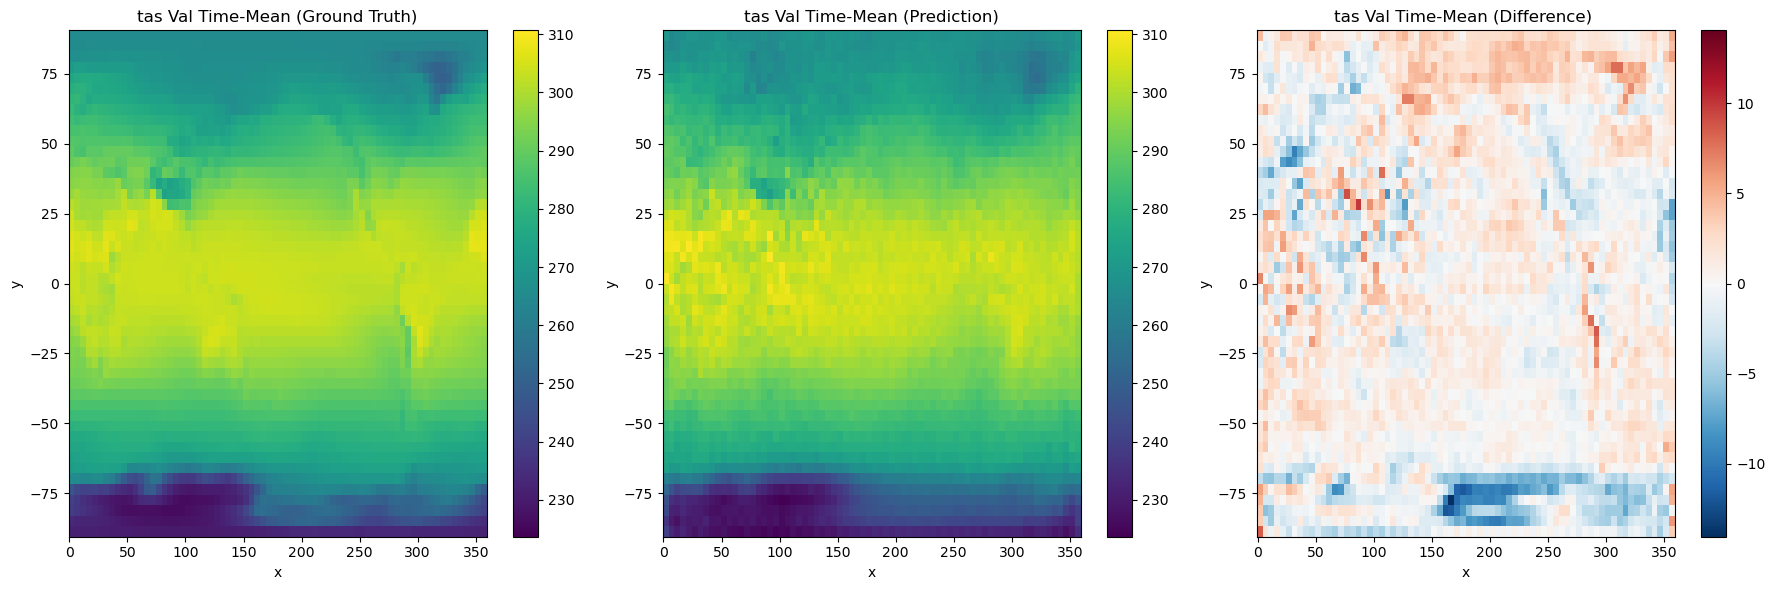

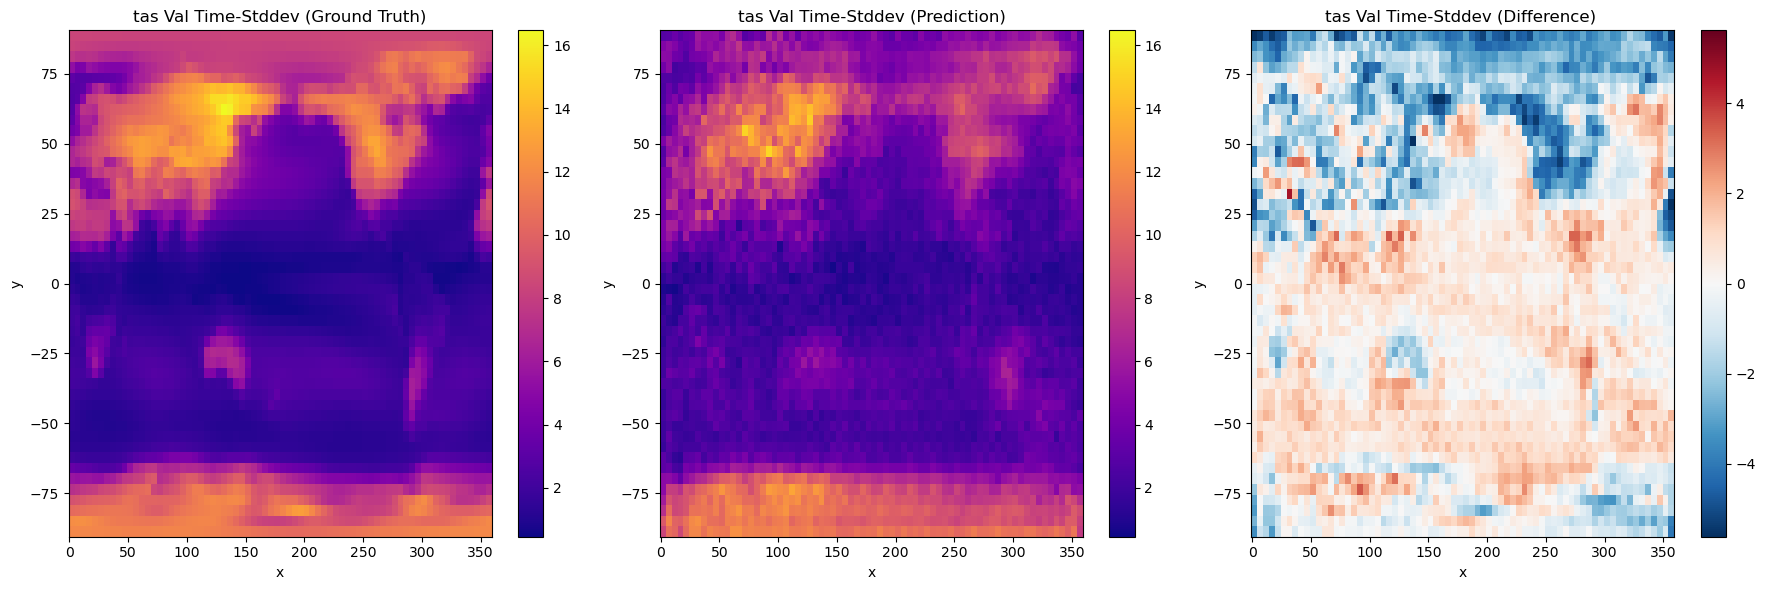

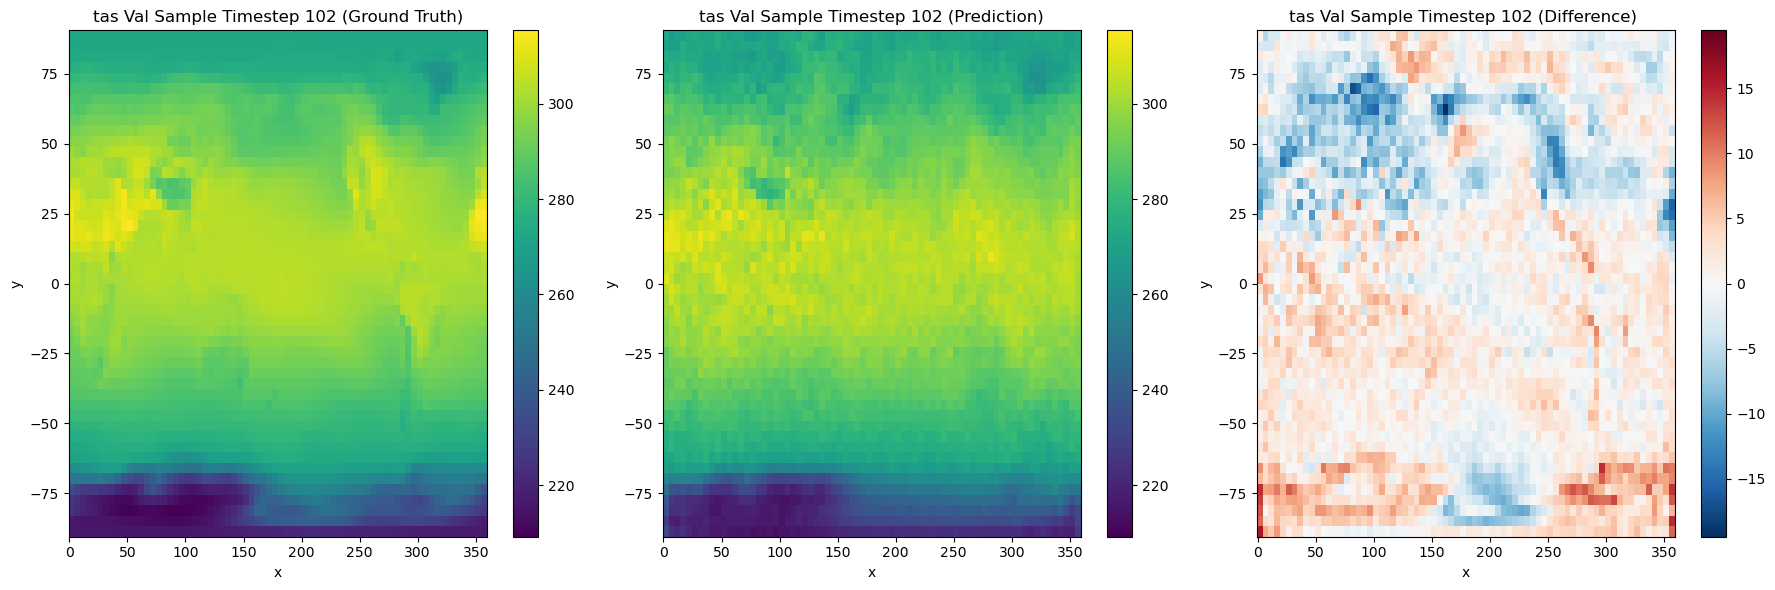

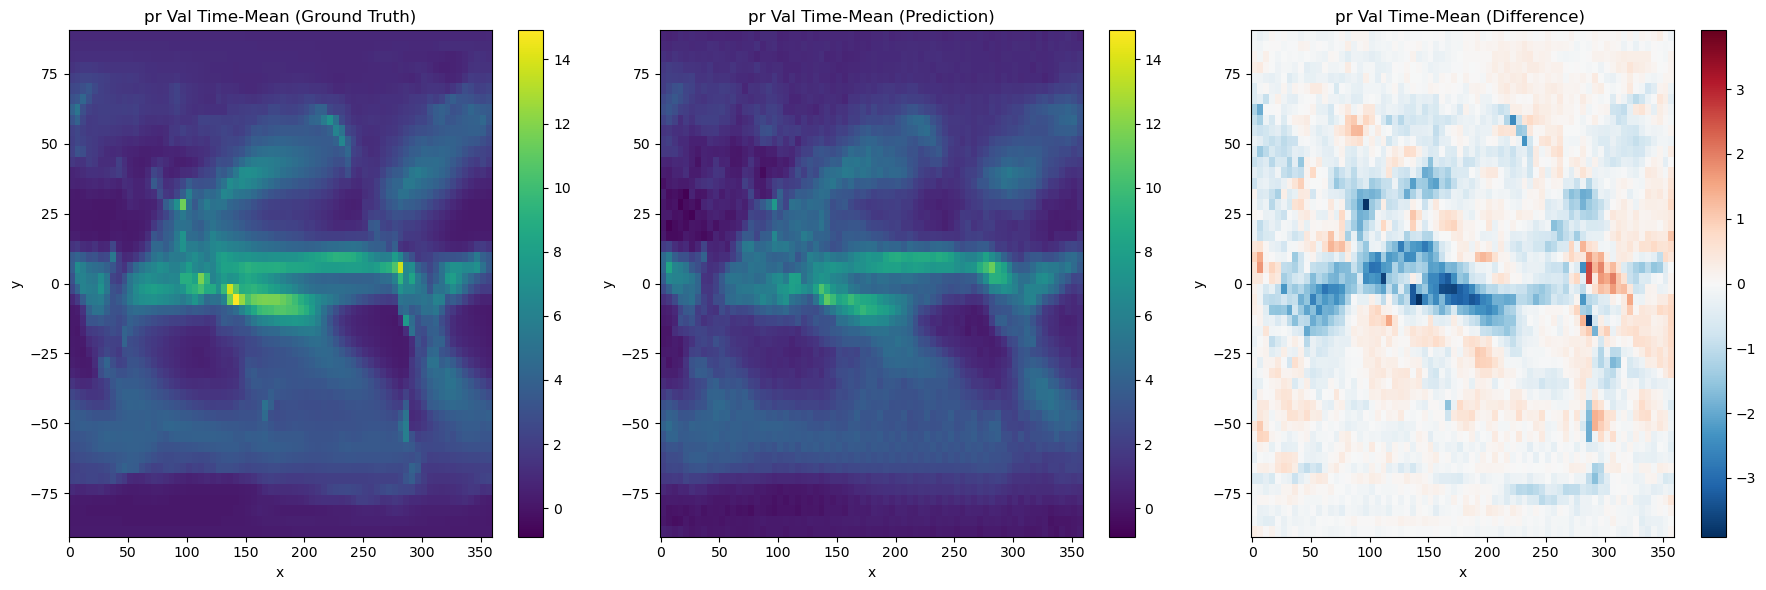

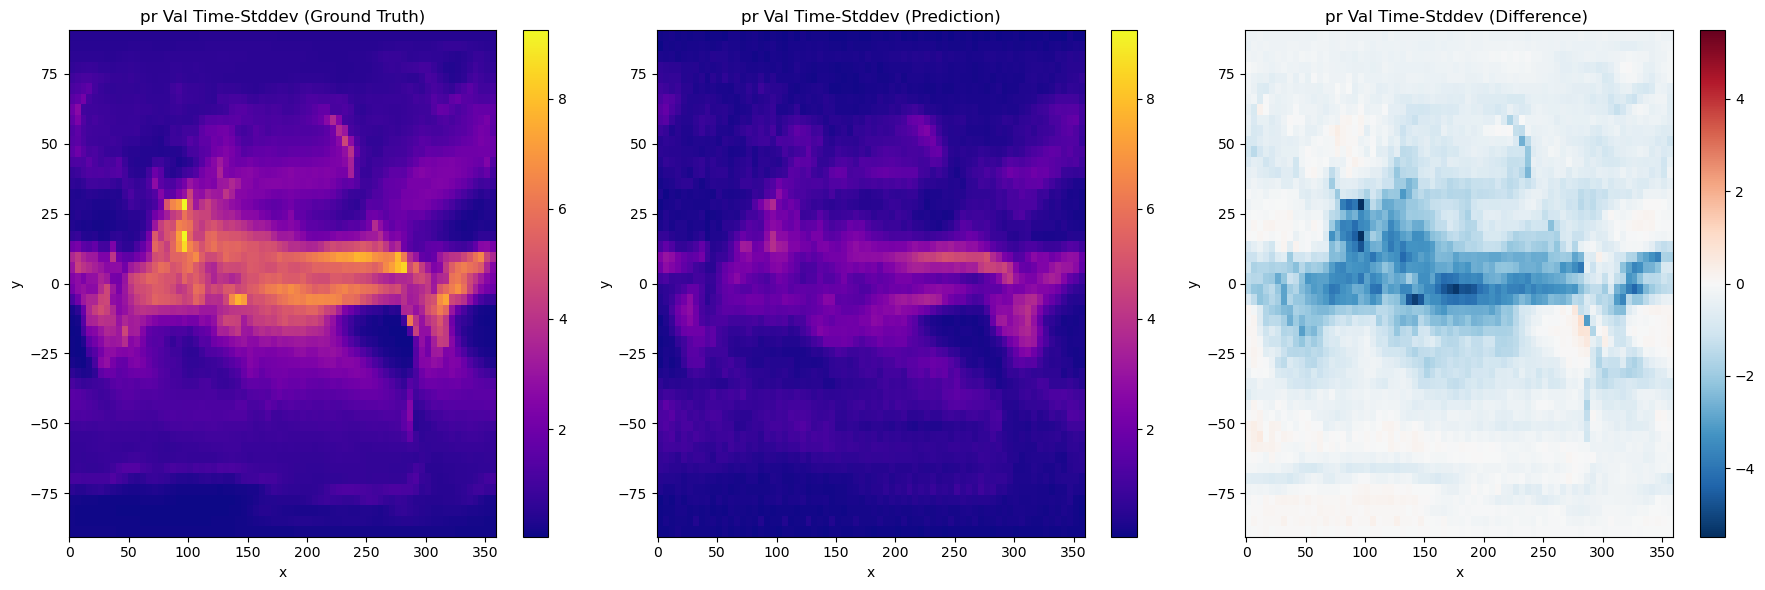

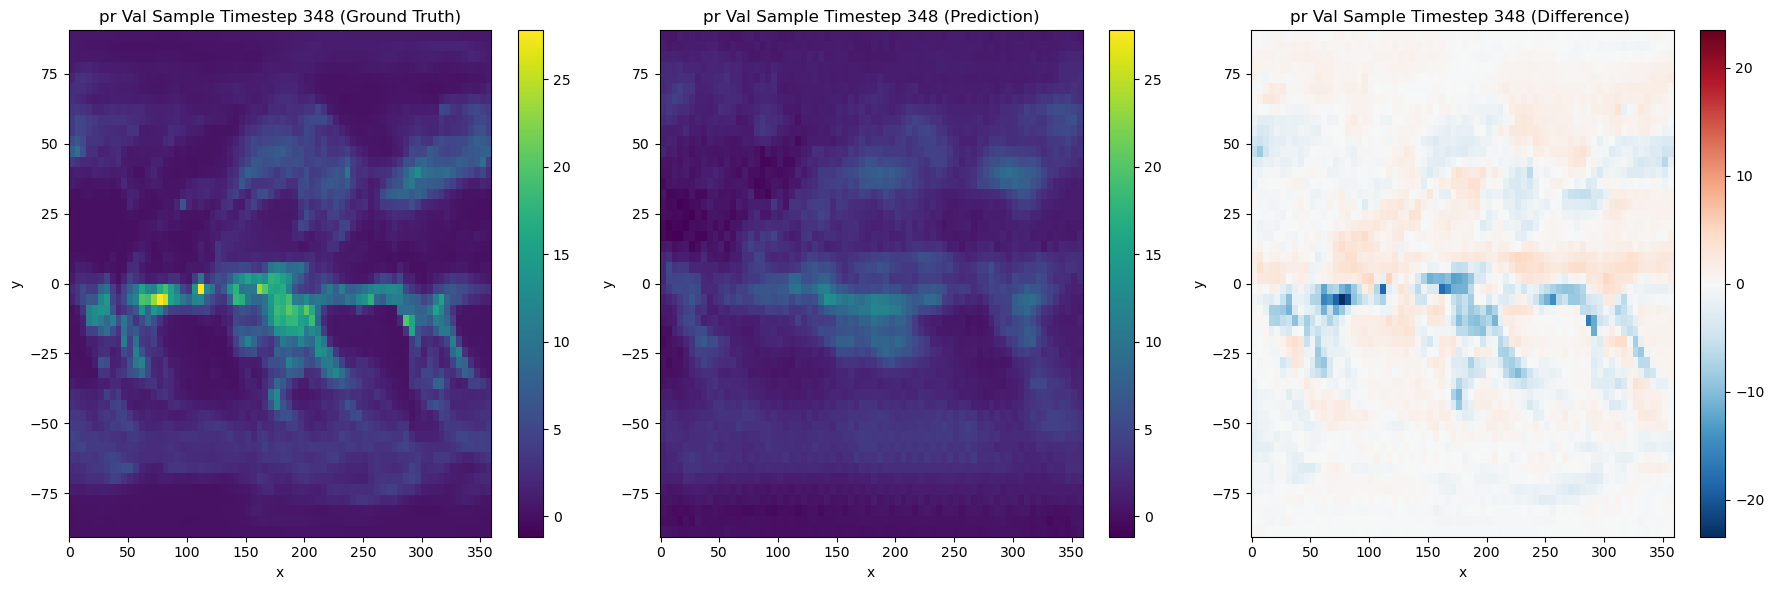

In [26]:
# Load validation predictions
# make sure to have run the validation loop at least once
val_preds = np.load("val_preds.npy")
val_trues = np.load("val_trues.npy")

lat, lon = datamodule.get_coords()
output_vars = datamodule.output_vars
time = np.arange(val_preds.shape[0])

for i, var in enumerate(output_vars):
    pred_xr = xr.DataArray(val_preds[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})
    true_xr = xr.DataArray(val_trues[:, i], dims=["time", "y", "x"], coords={"time": time, "y": lat, "x": lon})

    # --- Time Mean ---
    plot_comparison(true_xr.mean("time"), pred_xr.mean("time"), f"{var} Val Time-Mean")

    # --- Time Stddev ---
    plot_comparison(true_xr.std("time"), pred_xr.std("time"), f"{var} Val Time-Stddev", cmap="plasma")

    # --- Random timestep ---
    t_idx = np.random.randint(0, len(time))
    plot_comparison(true_xr.isel(time=t_idx), pred_xr.isel(time=t_idx), f"{var} Val Sample Timestep {t_idx}")


## 🧪 Final Notes

This notebook is meant to serve as a **baseline template** — a starting point to help you get up and running quickly with the climate emulation challenge.

You are **not** required to stick to this exact setup. In fact, we **encourage** you to:

- 🔁 Build on top of the provided `DataModule`. 
- 🧠 Use your own model architectures or training pipelines that you’re more comfortable with 
- ⚗️ Experiment with ideas  
- 🥇 Compete creatively to climb the Kaggle leaderboard  
- 🙌 Most importantly: **have fun** and **learn as much as you can** along the way

This challenge simulates a real-world scientific problem, and there’s no single "correct" approach — so be curious, experiment boldly, and make it your own!
